In [1]:
import os
import re
import time 
import joblib 
import json 

# 데이터 처리 및 모델링
import numpy as np
import pandas as pd
from tqdm import tqdm 

# 텍스트 전처리 (NLTK, Gensim)
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords as gensim_remove_stopwords

# Gensim LDA 및 평가
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel

# Scikit-learn NMF 및 평가
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# BERTopic
from bertopic import BERTopic
from umap import UMAP
import hdbscan
import torch

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
# ==============================================================================
# 0. 설정값 정의 및 랜덤 시드 고정
# ==============================================================================
print("--- 0. 설정값 정의 및 랜덤 시드 고정 ---")

FOLDER_PATH = './text'  # 텍스트 파일이 있는 폴더 경로
TOPIC_RANGE = range(2, 9) # LDA, NMF에서 테스트할 토픽 수 범위 (2 ~ 8)
MIN_TOPIC_SIZE_RANGE = range(2, 9) # BERTopic에서 테스트할 min_topic_size 범위 (2 ~ 8)
N_TOP_WORDS = 10 # Coherence 계산 및 토픽 확인 시 사용할 상위 단어 수
RANDOM_STATE = 42 # 재현성을 위한 랜덤 시드

print(f"전역 랜덤 시드 고정 (seed={RANDOM_STATE})")
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    print("PyTorch CUDA 시드 고정")
    torch.cuda.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed_all(RANDOM_STATE)

--- 0. 설정값 정의 및 랜덤 시드 고정 ---
전역 랜덤 시드 고정 (seed=42)


In [3]:
# ==============================================================================
# 1. 데이터 로딩 및 전처리
# ==============================================================================
print("\n--- 1. 데이터 로딩 및 전처리 시작 ---")

texts_original = []
if not os.path.isdir(FOLDER_PATH):
    print(f"오류: 폴더 '{FOLDER_PATH}'를 찾을 수 없습니다.")
    exit()

print(f"'{FOLDER_PATH}' 에서 텍스트 파일 로딩 중...")
file_list = sorted([f for f in os.listdir(FOLDER_PATH) if f.endswith('.txt')])
for filename in file_list:
    file_path = os.path.join(FOLDER_PATH, filename)
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            texts_original.append(f.read())
    except Exception as e:
        print(f"오류: 파일 '{filename}' 읽기 실패 - {e}")

if not texts_original:
    print("오류: 텍스트 파일 없음.")
    exit()
print(f"총 {len(texts_original)}개의 문서를 불러왔습니다.")

# 전처리 준비
stop_words_nltk = stopwords.words('english')
stop_words_nltk.extend(["etc", "et al", "figure", "table", "e.g.", "i.e.", 'vol', 'pp',
                        'introduction', 'abstract', 'paper', 'author', 'fig', 'page', 'number'])
lemmatizer = WordNetLemmatizer()

# 전처리 함수
def preprocess_text_simple(text):
    processed_tokens = []
    tokens = simple_preprocess(text, deacc=True)
    for token in tokens:
        if token not in stop_words_nltk and len(token) > 2 and token.isalpha():
            lemmatized_token = lemmatizer.lemmatize(token, pos='v')
            processed_tokens.append(lemmatizer.lemmatize(lemmatized_token, pos='n'))
    return processed_tokens

# 전처리 적용
print("텍스트 데이터 전처리 중...")
processed_texts_all = [preprocess_text_simple(doc) for doc in tqdm(texts_original)]

# 빈 문서 제거
valid_indices = [i for i, doc in enumerate(processed_texts_all) if doc]
processed_texts = [processed_texts_all[i] for i in valid_indices]

if len(processed_texts) != len(texts_original):
     print(f"주의: 전처리 후 {len(texts_original) - len(processed_texts)}개의 빈 문서 제외됨.")
if not processed_texts:
    print("\n오류: 유효한 텍스트 데이터 없음.")
    exit()
print(f"전처리 후 유효한 문서 수: {len(processed_texts)}")
print("--- 1. 데이터 로딩 및 전처리 완료 ---")


--- 1. 데이터 로딩 및 전처리 시작 ---
'./text' 에서 텍스트 파일 로딩 중...
총 16개의 문서를 불러왔습니다.
텍스트 데이터 전처리 중...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.32it/s]

전처리 후 유효한 문서 수: 16
--- 1. 데이터 로딩 및 전처리 완료 ---


In [4]:
# ==============================================================================
# 2. 모델 공통 데이터 준비 (Dictionary, Corpus, TF-IDF)
# ==============================================================================
print("\n--- 2. 모델 공통 데이터 준비 시작 ---")
start_time_prep = time.time()

# Gensim Dictionary 및 Corpus
print("Gensim Dictionary 및 Corpus 생성 중...")
id2word_common = corpora.Dictionary(processed_texts)
corpus_bow = [id2word_common.doc2bow(text) for text in processed_texts]
print("Gensim 데이터 준비 완료.")

# TF-IDF Matrix
print("TF-IDF Matrix 생성 중...")
texts_for_vectorizers = [' '.join(doc) for doc in processed_texts]
# TF-IDF 파라미터 확인!
vectorizer_tfidf = TfidfVectorizer(max_df=0.85, min_df=3,
                                   stop_words='english',
                                   ngram_range=(1,1),
                                   max_features=5000)
tfidf_matrix = vectorizer_tfidf.fit_transform(texts_for_vectorizers)
tfidf_feature_names = vectorizer_tfidf.get_feature_names_out()
print(f"TF-IDF Matrix 생성 완료: shape={tfidf_matrix.shape}")

# BERTopic 입력용 텍스트
texts_for_bertopic = [' '.join(doc) for doc in processed_texts]

prep_time = time.time() - start_time_prep
print(f"--- 2. 모델 공통 데이터 준비 완료 (소요 시간: {prep_time:.2f}초) ---")


--- 2. 모델 공통 데이터 준비 시작 ---
Gensim Dictionary 및 Corpus 생성 중...
Gensim 데이터 준비 완료.
TF-IDF Matrix 생성 중...
TF-IDF Matrix 생성 완료: shape=(16, 1322)
--- 2. 모델 공통 데이터 준비 완료 (소요 시간: 0.06초) ---


In [5]:
# ==============================================================================
# 3. 평가 지표 계산 함수 정의
# ==============================================================================
print("\n--- 3. 평가 지표 계산 함수 정의 ---")

def get_top_n_words_lda(lda_model, n_top_words):
    topics = []
    for i in range(lda_model.num_topics):
        topic_terms = lda_model.show_topic(i, topn=n_top_words)
        topics.append([word for word, prob in topic_terms])
    return topics

def get_top_n_words_nmf(model_components, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model_components):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append(top_features)
    return topics

def calculate_coherence(topic_words, processed_texts, dictionary, coherence_type='c_v'):
    if not topic_words or not processed_texts or not dictionary or not topic_words[0]: return np.nan
    try:
        coherence_model = CoherenceModel(topics=topic_words, texts=processed_texts, dictionary=dictionary, coherence=coherence_type)
        return coherence_model.get_coherence()
    except Exception as e: print(f"Warning: Coherence 계산 오류 - {e}"); return np.nan

def calculate_topic_diversity(topic_words):
    if not topic_words or len(topic_words) == 0 or not topic_words[0]: return 0.0
    n_top_words = len(topic_words[0])
    unique_words = set(word for topic in topic_words for word in topic[:n_top_words])
    total_words = len(topic_words) * n_top_words
    return len(unique_words) / total_words if total_words > 0 else 0.0

def get_doc_topic_assignments_lda(lda_model, corpus):
    assignments = []
    for bow in corpus:
        topic_probs = lda_model.get_document_topics(bow, minimum_probability=0)
        if topic_probs:
            assignments.append(max(topic_probs, key=lambda item: item[1])[0])
        else:
            assignments.append(-1)
    return np.array(assignments)

def get_doc_topic_assignments_nmf(nmf_model, doc_term_matrix):
    doc_topic_matrix = nmf_model.transform(doc_term_matrix)
    assignments = np.argmax(doc_topic_matrix, axis=1)
    assignments[np.sum(doc_topic_matrix, axis=1) == 0] = -1
    return assignments

def calculate_topic_size_balance_std(topic_assignments, ignore_topic=-1):
    if topic_assignments is None or len(topic_assignments) == 0: return np.nan
    filtered_assignments = topic_assignments[topic_assignments != ignore_topic]
    if len(filtered_assignments) == 0: return 0.0
    sizes = pd.Series(filtered_assignments).value_counts()
    return sizes.std()


--- 3. 평가 지표 계산 함수 정의 ---


In [6]:
# ==============================================================================
# 4. 모든 모델 결과를 저장할 리스트 초기화
# ==============================================================================
all_model_results = []


--- 5. LDA 모델 성능 측정 시작 ---
LDA 모델 학습 및 평가 (토픽 수 2 ~ 8)...


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:10<00:00, 10.13s/it]


LDA 모델 평가 결과 (Coherence & Perplexity):
 Num Topics  Coherence (C_v)  Log Perplexity
          2           0.4251         -6.8600
          3           0.4259         -6.8420
          4           0.4819         -6.8055
          5           0.4355         -6.7977
          6           0.4717         -6.7898
          7           0.4631         -6.7763
          8           0.4474         -6.7940


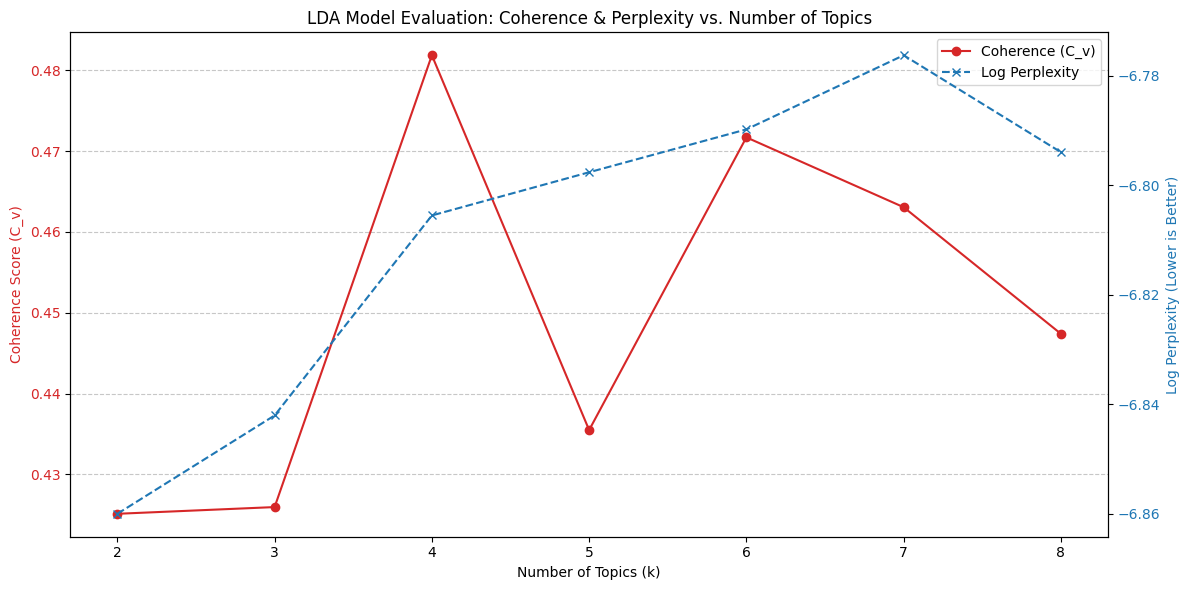

--- 5. LDA 모델 성능 측정 완료 ---


In [7]:
# ==============================================================================
# 5. LDA 모델 성능 측정
# ==============================================================================
print("\n--- 5. LDA 모델 성능 측정 시작 ---")
lda_results_for_df = [] # 기존 DataFrame용

print(f"LDA 모델 학습 및 평가 (토픽 수 {min(TOPIC_RANGE)} ~ {max(TOPIC_RANGE)})...")
for k in tqdm(TOPIC_RANGE):
    model_name = f'LDA (k={k})'
    start_time = time.time()
    coherence_cv, perplexity, diversity, size_std = np.nan, np.nan, np.nan, np.nan
    lda_assignments = None
    try:
        lda_model = LdaModel(corpus=corpus_bow, id2word=id2word_common, num_topics=k,
                             random_state=RANDOM_STATE, update_every=1, chunksize=16,
                             passes=10, alpha='auto', per_word_topics=True)

        perplexity = lda_model.log_perplexity(corpus_bow)
        lda_top_words = get_top_n_words_lda(lda_model, N_TOP_WORDS)
        coherence_cv = calculate_coherence(lda_top_words, processed_texts, id2word_common)
        diversity = calculate_topic_diversity(lda_top_words)
        lda_assignments = get_doc_topic_assignments_lda(lda_model, corpus_bow)
        size_std = calculate_topic_size_balance_std(lda_assignments)
        elapsed_time = time.time() - start_time

        result_dict = {
            'Model': model_name, 'Parameter_Value': k, 'Parameter_Type': 'k',
            'Num Topics': k, 'Coherence (C_v)': coherence_cv, 'Log Perplexity': perplexity,
            'Topic Diversity': diversity, 'Topic Size StdDev': size_std,
            'Time (sec)': elapsed_time
        }
        lda_results_for_df.append({'Num Topics': k, 'Coherence (C_v)': coherence_cv, 'Log Perplexity': perplexity})
        all_model_results.append(result_dict)

    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"  {model_name} 처리 중 오류 발생: {e}")
        all_model_results.append({
            'Model': model_name, 'Parameter_Value': k, 'Parameter_Type': 'k', 'Num Topics': k,
            'Coherence (C_v)': np.nan, 'Log Perplexity': np.nan, 'Topic Diversity': np.nan,
            'Topic Size StdDev': np.nan, 'Time (sec)': elapsed_time
        })
        lda_results_for_df.append({'Num Topics': k, 'Coherence (C_v)': np.nan, 'Log Perplexity': np.nan})

# 기존 LDA 결과 처리 및 시각화 (유지)
lda_results_df = pd.DataFrame(lda_results_for_df).dropna(subset=['Coherence (C_v)', 'Log Perplexity'], how='all')
print("\nLDA 모델 평가 결과 (Coherence & Perplexity):")
if not lda_results_df.empty:
    print(lda_results_df.round(4).to_string(index=False))
    try: # 시각화 오류 방지용 try-except 추가
        fig, ax1 = plt.subplots(figsize=(12, 6))
        color = 'tab:red'
        ax1.set_xlabel('Number of Topics (k)')
        ax1.set_ylabel('Coherence Score (C_v)', color=color)
        line1 = ax1.plot(lda_results_df['Num Topics'], lda_results_df['Coherence (C_v)'], color=color, marker='o', label='Coherence (C_v)')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Log Perplexity (Lower is Better)', color=color)
        valid_perplexity = lda_results_df.dropna(subset=['Log Perplexity'])
        if not valid_perplexity.empty:
           line2 = ax2.plot(valid_perplexity['Num Topics'], valid_perplexity['Log Perplexity'], color=color, marker='x', linestyle='--', label='Log Perplexity')
        else: line2 = []
        ax2.tick_params(axis='y', labelcolor=color)
        lines = line1 + (line2 if line2 else [])
        labels = [l.get_label() for l in lines]
        if lines: ax1.legend(lines, labels, loc='best')
        plt.title('LDA Model Evaluation: Coherence & Perplexity vs. Number of Topics')
        plt.xticks(sorted(lda_results_df['Num Topics'].unique().astype(int))) # 정렬 추가
        fig.tight_layout()
        plt.show()
    except Exception as e_vis:
        print(f"LDA 결과 시각화 중 오류 발생: {e_vis}")
else:
    print("LDA 결과를 시각화할 수 없습니다.")
print("--- 5. LDA 모델 성능 측정 완료 ---")


--- 6. NMF 모델 성능 측정 시작 ---
NMF 모델 학습 및 평가 (토픽 수 2 ~ 8)...


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:07<00:00,  9.58s/it]


NMF 모델 평가 결과 (Coherence):
 Num Topics  Coherence (C_v)
          2           0.5817
          3           0.5860
          4           0.5473
          5           0.6192
          6           0.6367
          7           0.6028
          8           0.5993


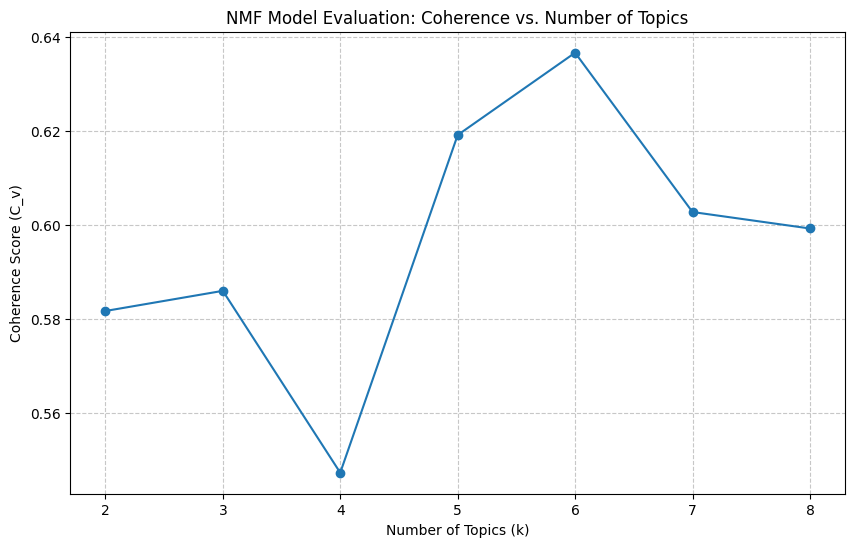

--- 6. NMF 모델 성능 측정 완료 ---


In [8]:
# ==============================================================================
# 6. NMF 모델 성능 측정
# ==============================================================================
print("\n--- 6. NMF 모델 성능 측정 시작 ---")
nmf_results_for_df = [] # 기존 DataFrame용

print(f"NMF 모델 학습 및 평가 (토픽 수 {min(TOPIC_RANGE)} ~ {max(TOPIC_RANGE)})...")
for k in tqdm(TOPIC_RANGE):
    model_name = f'NMF (k={k})'
    start_time = time.time()
    coherence_cv, diversity, size_std = np.nan, np.nan, np.nan
    nmf_assignments = None
    try:
        nmf_model = NMF(n_components=k, random_state=RANDOM_STATE, init='nndsvda',
                        max_iter=400, solver='cd', l1_ratio=0.0)
        W = nmf_model.fit_transform(tfidf_matrix)
        H = nmf_model.components_

        nmf_top_words = get_top_n_words_nmf(H, tfidf_feature_names, N_TOP_WORDS)
        coherence_cv = calculate_coherence(nmf_top_words, processed_texts, id2word_common)
        diversity = calculate_topic_diversity(nmf_top_words)
        nmf_assignments = get_doc_topic_assignments_nmf(nmf_model, tfidf_matrix)
        size_std = calculate_topic_size_balance_std(nmf_assignments)
        elapsed_time = time.time() - start_time

        result_dict = {
            'Model': model_name, 'Parameter_Value': k, 'Parameter_Type': 'k',
            'Num Topics': k, 'Coherence (C_v)': coherence_cv, 'Log Perplexity': np.nan,
            'Topic Diversity': diversity, 'Topic Size StdDev': size_std,
            'Time (sec)': elapsed_time
        }
        nmf_results_for_df.append({'Num Topics': k, 'Coherence (C_v)': coherence_cv})
        all_model_results.append(result_dict)

    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"  {model_name} 처리 중 오류 발생: {e}")
        all_model_results.append({
            'Model': model_name, 'Parameter_Value': k, 'Parameter_Type': 'k','Num Topics': k,
            'Coherence (C_v)': np.nan, 'Log Perplexity': np.nan, 'Topic Diversity': np.nan,
            'Topic Size StdDev': np.nan, 'Time (sec)': elapsed_time
        })
        nmf_results_for_df.append({'Num Topics': k, 'Coherence (C_v)': np.nan})

# 기존 NMF 결과 처리 및 시각화 (유지)
nmf_results_df = pd.DataFrame(nmf_results_for_df).dropna()
print("\nNMF 모델 평가 결과 (Coherence):")
if not nmf_results_df.empty:
    print(nmf_results_df.round(4).to_string(index=False))
    try: # 시각화 오류 방지용 try-except 추가
        plt.figure(figsize=(10, 6))
        plt.plot(nmf_results_df['Num Topics'], nmf_results_df['Coherence (C_v)'], marker='o')
        plt.xlabel('Number of Topics (k)')
        plt.ylabel('Coherence Score (C_v)')
        plt.title('NMF Model Evaluation: Coherence vs. Number of Topics')
        plt.xticks(sorted(nmf_results_df['Num Topics'].unique().astype(int))) # 정렬 추가
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    except Exception as e_vis:
        print(f"NMF 결과 시각화 중 오류 발생: {e_vis}")
else:
    print("NMF 결과를 시각화할 수 없습니다.")
print("--- 6. NMF 모델 성능 측정 완료 ---")


--- 7. BERTopic 모델 성능 측정 시작 ---
BERTopic 모델 학습 및 평가 (min_topic_size 2 ~ 8)...


 43%|████████████████████████████████████                                                | 3/7 [00:35<00:38,  9.69s/it]

  BERTopic (mts=4): 의미있는 토픽을 찾지 못했습니다.


 57%|████████████████████████████████████████████████                                    | 4/7 [00:38<00:21,  7.00s/it]

  BERTopic (mts=5): 의미있는 토픽을 찾지 못했습니다.


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:40<00:10,  5.47s/it]

  BERTopic (mts=6): 의미있는 토픽을 찾지 못했습니다.


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:44<00:04,  4.77s/it]

  BERTopic (mts=7): 의미있는 토픽을 찾지 못했습니다.


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:46<00:00,  6.69s/it]

  BERTopic (mts=8): 의미있는 토픽을 찾지 못했습니다.

BERTopic 모델 평가 결과 (Coherence & Topics Found):
 Min Topic Size  Num Topics Found  Coherence (C_v)
              2                 3           0.4807
              3                 2           0.4617
              4                 0           0.0000
              5                 0           0.0000
              6                 0           0.0000
              7                 0           0.0000
              8                 0           0.0000


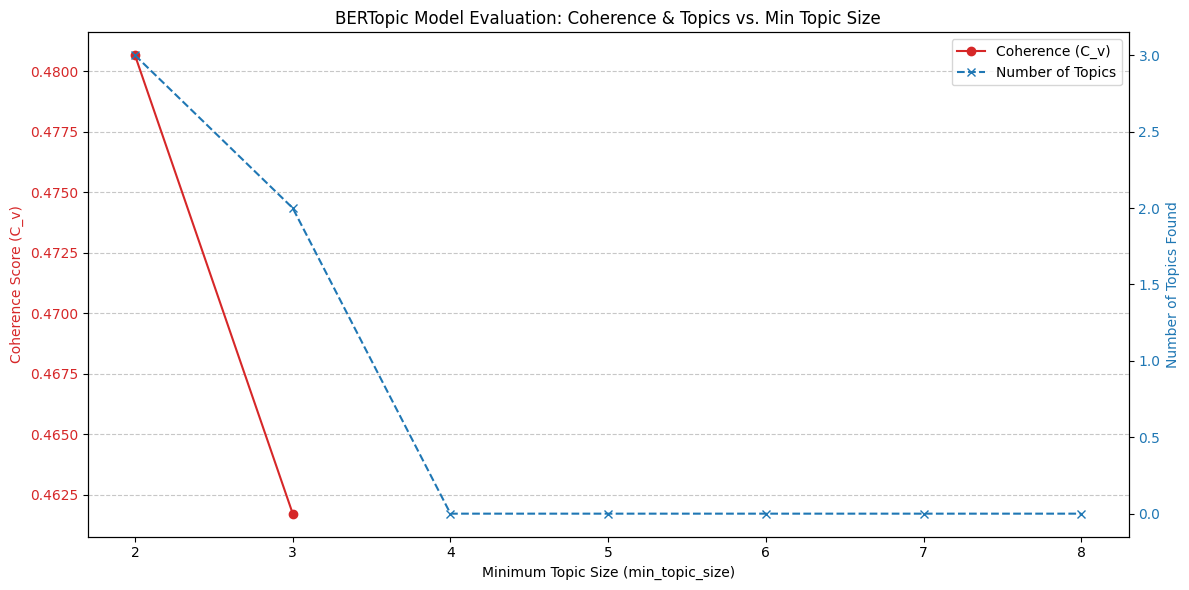

--- 7. BERTopic 모델 성능 측정 완료 ---


In [9]:
# ==============================================================================
# 7. BERTopic 모델 성능 측정
# ==============================================================================
print("\n--- 7. BERTopic 모델 성능 측정 시작 ---")
bertopic_results_for_df = [] # 기존 DataFrame용

print(f"BERTopic 모델 학습 및 평가 (min_topic_size {min(MIN_TOPIC_SIZE_RANGE)} ~ {max(MIN_TOPIC_SIZE_RANGE)})...")
for mts in tqdm(MIN_TOPIC_SIZE_RANGE):
    model_name = f'BERTopic (mts={mts})'
    start_time = time.time()
    num_meaningful_topics, coherence_cv, diversity, size_std = 0, np.nan, np.nan, np.nan
    bertopic_assignments = None
    try:
        umap_model_fixed = UMAP(n_neighbors=15, n_components=5, min_dist=0.0,
                                metric='cosine', random_state=RANDOM_STATE)
        bertopic_model = BERTopic(language="english", min_topic_size=mts,
                                  umap_model=umap_model_fixed, verbose=False,
                                  nr_topics=None)

        bertopic_assignments, _ = bertopic_model.fit_transform(texts_for_bertopic)

        topic_info = bertopic_model.get_topic_info()
        num_meaningful_topics = len(topic_info[topic_info.Topic != -1])

        if num_meaningful_topics > 0:
            bertopic_topic_dict = bertopic_model.get_topics()
            meaningful_topic_ids = sorted([tid for tid in bertopic_topic_dict if tid != -1])
            bertopic_top_words = [[word for word, score in bertopic_topic_dict[tid][:N_TOP_WORDS]]
                                  for tid in meaningful_topic_ids]
            coherence_cv = calculate_coherence(bertopic_top_words, processed_texts, id2word_common)
            diversity = calculate_topic_diversity(bertopic_top_words)
            size_std = calculate_topic_size_balance_std(np.array(bertopic_assignments))
        else:
            print(f"  {model_name}: 의미있는 토픽을 찾지 못했습니다.")
            coherence_cv = 0.0

        elapsed_time = time.time() - start_time

        result_dict = {
            'Model': model_name, 'Parameter_Value': mts, 'Parameter_Type': 'mts',
            'Num Topics': num_meaningful_topics, 'Coherence (C_v)': coherence_cv, 'Log Perplexity': np.nan,
            'Topic Diversity': diversity, 'Topic Size StdDev': size_std,
            'Time (sec)': elapsed_time
        }
        bertopic_results_for_df.append({'Min Topic Size': mts, 'Num Topics Found': num_meaningful_topics, 'Coherence (C_v)': coherence_cv})
        all_model_results.append(result_dict)

    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"  {model_name} 처리 중 오류 발생: {e}")
        all_model_results.append({
            'Model': model_name, 'Parameter_Value': mts, 'Parameter_Type': 'mts','Num Topics': 0,
            'Coherence (C_v)': np.nan, 'Log Perplexity': np.nan, 'Topic Diversity': np.nan,
            'Topic Size StdDev': np.nan, 'Time (sec)': elapsed_time
        })
        bertopic_results_for_df.append({'Min Topic Size': mts, 'Num Topics Found': 0, 'Coherence (C_v)': np.nan})


# 기존 BERTopic 결과 처리 및 시각화 (유지)
bertopic_results_df = pd.DataFrame(bertopic_results_for_df).dropna(subset=['Coherence (C_v)'])
print("\nBERTopic 모델 평가 결과 (Coherence & Topics Found):")
if not bertopic_results_df.empty and bertopic_results_df['Num Topics Found'].sum() > 0:
    print(bertopic_results_df.round(4).to_string(index=False))
    try: # 시각화 오류 방지용 try-except 추가
        fig, ax1 = plt.subplots(figsize=(12, 6))
        color = 'tab:red'
        ax1.set_xlabel('Minimum Topic Size (min_topic_size)')
        ax1.set_ylabel('Coherence Score (C_v)', color=color)
        valid_coherence_df = bertopic_results_df[bertopic_results_df['Coherence (C_v)'] != 0].dropna(subset=['Coherence (C_v)'])
        if not valid_coherence_df.empty:
           line1 = ax1.plot(valid_coherence_df['Min Topic Size'], valid_coherence_df['Coherence (C_v)'], color=color, marker='o', label='Coherence (C_v)')
        else: line1 = []
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Number of Topics Found', color=color)
        valid_topics_df = bertopic_results_df.dropna(subset=['Num Topics Found', 'Min Topic Size'])
        if not valid_topics_df.empty:
           line2 = ax2.plot(valid_topics_df['Min Topic Size'], valid_topics_df['Num Topics Found'], color=color, marker='x', linestyle='--', label='Number of Topics')
        else: line2 = []
        ax2.tick_params(axis='y', labelcolor=color)
        lines = (line1 if line1 else []) + (line2 if line2 else []) # 리스트 병합 수정
        labels = [l.get_label() for l in lines]
        if lines: ax1.legend(lines, labels, loc='best')
        plt.title('BERTopic Model Evaluation: Coherence & Topics vs. Min Topic Size')
        plt.xticks(sorted(bertopic_results_df['Min Topic Size'].unique().astype(int))) # 정렬 추가
        fig.tight_layout()
        plt.show()
    except Exception as e_vis:
        print(f"BERTopic 결과 시각화 중 오류 발생: {e_vis}")
else:
    print("BERTopic 결과를 시각화할 수 없습니다.")
print("--- 7. BERTopic 모델 성능 측정 완료 ---")


--- 8. 최종 지정 모델 비교 시작 ---

--- 지정된 모델 성능 지표 비교표 ---
           Model  Num Topics  Coherence (C_v)  Topic Diversity  Topic Size StdDev Log Perplexity  Time (sec)
       LDA (k=4)           4           0.4819           0.5750             2.8284        -6.8055     10.0641
       NMF (k=6)           6           0.6367           0.9500             1.2111              -      9.4509
BERTopic (mts=2)           3           0.4807           0.7667             2.5166              -     20.6163

--- 성능 지표 통합 시각화 ---


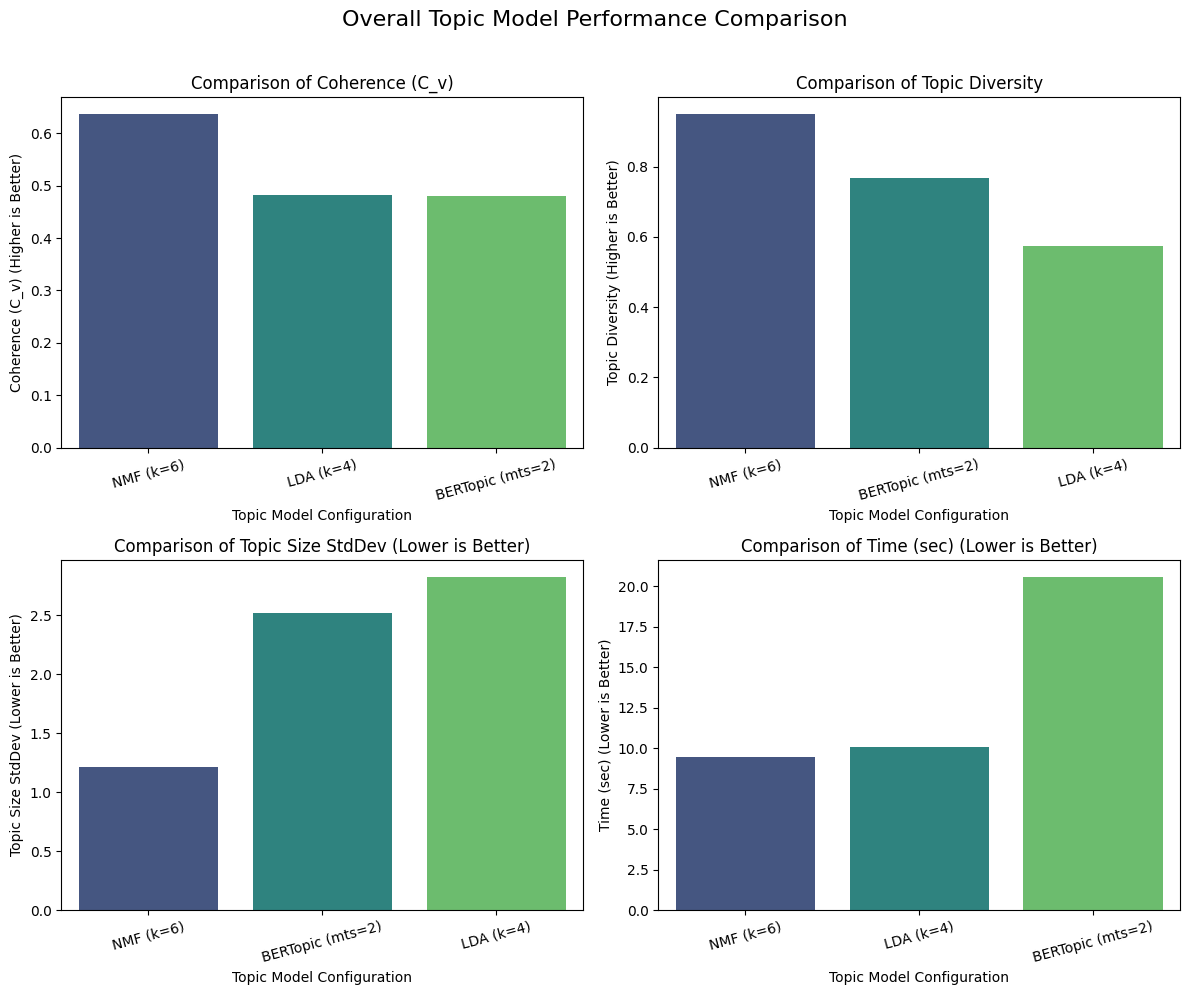

--- 8. 최종 지정 모델 비교 완료 ---


In [11]:
# ==============================================================================
# 8. 최종 지정 모델 비교
# ==============================================================================
print("\n--- 8. 최종 지정 모델 비교 시작 ---")

# 비교 대상 모델 및 파라미터 값 지정
target_models_params = {
    'LDA': [4],
    'NMF': [6],
    'BERTopic': [2]
}

# 전체 결과 리스트에서 필요한 데이터 필터링
filtered_results = []
if all_model_results:
    all_results_df = pd.DataFrame(all_model_results)

    for model_prefix, param_values in target_models_params.items():
        for param_val in param_values:
            if model_prefix == 'BERTopic':
                 condition = (all_results_df['Model'].str.startswith(model_prefix)) & \
                             (all_results_df['Parameter_Type'] == 'mts') & \
                             (all_results_df['Parameter_Value'] == param_val)
            else:
                 condition = (all_results_df['Model'].str.startswith(model_prefix)) & \
                             (all_results_df['Parameter_Type'] == 'k') & \
                             (all_results_df['Parameter_Value'] == param_val)
            found_row = all_results_df[condition]
            if not found_row.empty:
                filtered_results.append(found_row.iloc[0].to_dict())
            else:
                model_name_to_find = f"{model_prefix} ({'mts' if model_prefix == 'BERTopic' else 'k'}={param_val})"
                print(f"주의: '{model_name_to_find}'에 해당하는 결과를 찾을 수 없습니다.")
else:
    print("오류: 모델 평가 결과가 없습니다 ('all_model_results' 리스트가 비어 있음).")

# 최종 비교 DataFrame 생성 및 출력
if filtered_results:
    comparison_final_df = pd.DataFrame(filtered_results)

    display_columns = [
        'Model', 'Num Topics', 'Coherence (C_v)', 'Topic Diversity',
        'Topic Size StdDev', 'Log Perplexity', 'Time (sec)'
    ]
    existing_display_columns = [col for col in display_columns if col in comparison_final_df.columns]
    comparison_display_df = comparison_final_df[existing_display_columns].copy()

    comparison_display_df.fillna('-', inplace=True)
    float_cols = ['Coherence (C_v)', 'Topic Diversity', 'Topic Size StdDev', 'Log Perplexity', 'Time (sec)']
    for col in float_cols:
        if col in comparison_display_df.columns:
             comparison_display_df[col] = pd.to_numeric(comparison_display_df[col].replace('-', np.nan), errors='coerce')
             comparison_display_df[col] = comparison_display_df[col].round(4)
    comparison_display_df.fillna('-', inplace=True)

    print("\n--- 지정된 모델 성능 지표 비교표 ---")
    print(comparison_display_df.to_string(index=False))

    # 성능 지표 통합 시각화
    print("\n--- 성능 지표 통합 시각화 ---")
    metrics_to_plot = [
        'Coherence (C_v)',
        'Topic Diversity',
        'Topic Size StdDev',
        'Time (sec)'
    ]
    metrics_to_plot = [m for m in metrics_to_plot if m in comparison_display_df.columns]

    if metrics_to_plot:
        num_metrics = len(metrics_to_plot)
        ncols = 2 if num_metrics > 1 else 1
        nrows = (num_metrics + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5))
        axes = np.array(axes).flatten()

        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i]
            plot_data = comparison_display_df.copy()
            plot_data[metric] = pd.to_numeric(plot_data[metric].replace('-', np.nan), errors='coerce')
            plot_data.dropna(subset=[metric], inplace=True)

            if not plot_data.empty:
                 ascending_order = False
                 plot_title = f'Comparison of {metric}'
                 y_label = f'{metric} (Higher is Better)'

                 if metric in ['Topic Size StdDev', 'Time (sec)']:
                     ascending_order = True
                     plot_title += ' (Lower is Better)'
                     y_label = f'{metric} (Lower is Better)'

                 order = plot_data.sort_values(metric, ascending=ascending_order)['Model']
                 sns.barplot(x='Model', y=metric, data=plot_data, palette='viridis', order=order, ax=ax)

                 ax.set_title(plot_title, fontsize=12)
                 ax.set_ylabel(y_label)
                 ax.set_xlabel('Topic Model Configuration')
                 ax.tick_params(axis='x', rotation=15)
            else:
                 ax.set_title(f'{metric} (No data)', fontsize=12)
                 ax.text(0.5, 0.5, 'No valid data to plot', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        fig.suptitle('Overall Topic Model Performance Comparison', fontsize=16, y=1.02)
        plt.show()

    else:
        print("\n시각화할 유효한 성능 지표 데이터가 없습니다.")

else:
    print("\n비교할 최종 모델 결과 데이터가 없습니다.")

print("--- 8. 최종 지정 모델 비교 완료 ---")

In [12]:
# ==============================================================================
# 9. 선택된 모델(NMF k=6) 새로 학습 및 저장
# ==============================================================================
print("\n--- 9. 선택된 모델(NMF k=6) 새로 학습 및 저장 시작 ---")
print("주의: NMF(k=6) 모델을 다시 학습하여 저장합니다.")

SAVE_DIR = './model_save'

try:
    os.makedirs(SAVE_DIR, exist_ok=True)
    print(f"결과를 저장할 폴더: '{os.path.abspath(SAVE_DIR)}'")
except OSError as e:
    print(f"오류: 저장 폴더 '{SAVE_DIR}' 생성 실패 - {e}")
    print("현재 디렉토리에 저장합니다.")
    SAVE_DIR = '.'

k_to_save = 6

nmf_model_base_filename = f'nmf_k{k_to_save}_model_final.joblib'
vectorizer_base_filename = 'tfidf_vectorizer_final.joblib'
topics_base_filename = f'nmf_k{k_to_save}_topics_final.txt'
info_base_filename = f'nmf_k{k_to_save}_info_final.json'

nmf_model_filepath = os.path.join(SAVE_DIR, nmf_model_base_filename)
vectorizer_filepath = os.path.join(SAVE_DIR, vectorizer_base_filename)
topics_filepath = os.path.join(SAVE_DIR, topics_base_filename)
info_filepath = os.path.join(SAVE_DIR, info_base_filename)

nmf_model_to_save = None
nmf_top_words_to_save = None
nmf_metrics_to_save = {}

try:
    print(f"NMF(k={k_to_save}) 모델을 새로 학습합니다...")
    start_time_save = time.time()
    nmf_model_to_save = NMF(n_components=k_to_save,
                            random_state=RANDOM_STATE,
                            init='nndsvda',
                            max_iter=400,
                            solver='cd',
                            l1_ratio=0.0)

    if 'tfidf_matrix' in locals() and 'tfidf_feature_names' in locals():
        nmf_model_to_save.fit(tfidf_matrix)
        H_save = nmf_model_to_save.components_
        nmf_top_words_to_save = get_top_n_words_nmf(H_save, tfidf_feature_names, N_TOP_WORDS)
        elapsed_time_save = time.time() - start_time_save
        print(f"NMF(k={k_to_save}) 모델 재학습 완료 (소요 시간: {elapsed_time_save:.2f}초)")

        if all_model_results:
            target_model_name = f'NMF (k={k_to_save})'
            for result in all_model_results:
                if result.get('Model') == target_model_name:
                    nmf_metrics_to_save = result.copy()
                    break
            if not nmf_metrics_to_save:
                print(f"주의: all_model_results에서 {target_model_name}의 성능 지표를 찾지 못했습니다.")
        else:
            print("주의: 성능 지표를 가져올 all_model_results 리스트가 비어있습니다.")

        joblib.dump(nmf_model_to_save, nmf_model_filepath)
        print(f"새로 학습된 NMF(k={k_to_save}) 모델 객체를 '{nmf_model_filepath}'으로 저장했습니다.")

        if 'vectorizer_tfidf' in locals():
            joblib.dump(vectorizer_tfidf, vectorizer_filepath)
            print(f"TF-IDF Vectorizer 객체를 '{vectorizer_filepath}'으로 저장했습니다.")
        else:
             print("저장할 TF-IDF Vectorizer 객체('vectorizer_tfidf')가 없습니다.")

        if nmf_top_words_to_save:
            with open(topics_filepath, 'w', encoding='utf-8') as f:
                f.write(f"--- NMF (k={k_to_save}) Top {N_TOP_WORDS} Words per Topic (Final Saved Model) ---\n")
                for i, words in enumerate(nmf_top_words_to_save):
                    f.write(f"Topic {i}: {', '.join(words)}\n")
            print(f"NMF(k={k_to_save}) 토픽 단어를 '{topics_filepath}'으로 저장했습니다.")
        else:
            print("저장할 NMF(k={k_to_save}) 토픽 단어 정보가 없습니다.")

        info_to_save = {
            'model_type': 'NMF',
            'num_topics_k': k_to_save,
            'random_state': RANDOM_STATE,
            'tfidf_vectorizer_params': str(vectorizer_tfidf.get_params()) if 'vectorizer_tfidf' in locals() else 'Vectorizer not found',
            'nmf_model_params': str(nmf_model_to_save.get_params()) if nmf_model_to_save is not None else 'Model not found',
            'performance_metrics_from_first_run': nmf_metrics_to_save
        }

        def convert_to_serializable(obj):
            if isinstance(obj, np.integer): return int(obj)
            elif isinstance(obj, np.floating):
                if np.isnan(obj): return None
                elif np.isinf(obj): return None
                else: return float(obj)
            elif isinstance(obj, np.ndarray): return obj.tolist()
            elif isinstance(obj, dict): return {k: convert_to_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, list): return [convert_to_serializable(elem) for elem in obj]
            elif isinstance(obj, type): return str(obj)
            try:
                json.dumps(obj)
                return obj
            except TypeError:
                return str(obj)

        try:
            info_to_save_serializable = convert_to_serializable(info_to_save)
            with open(info_filepath, 'w', encoding='utf-8') as f:
                json.dump(info_to_save_serializable, f, indent=4, ensure_ascii=False)
            print(f"NMF(k={k_to_save}) 관련 정보를 '{info_filepath}'으로 저장했습니다.")
        except Exception as e:
            print(f"오류: 모델 정보 저장 실패 - {e}")
            import traceback
            traceback.print_exc()

    else:
        print("오류: NMF 모델 학습에 필요한 TF-IDF 행렬('tfidf_matrix') 또는 피처 이름('tfidf_feature_names')이 없습니다.")

except Exception as e:
    print(f"오류: NMF(k={k_to_save}) 모델 저장 과정 실패 - {e}")
    import traceback
    traceback.print_exc()


print("--- 9. 선택된 모델 새로 학습 및 저장 완료 ---")
print("\n--- 모든 작업 완료 ---")


--- 9. 선택된 모델(NMF k=6) 새로 학습 및 저장 시작 ---
주의: NMF(k=6) 모델을 다시 학습하여 저장합니다.
결과를 저장할 폴더: 'C:\temo\Research\AHDL\paper_LDA\real\model_save'
NMF(k=6) 모델을 새로 학습합니다...
NMF(k=6) 모델 재학습 완료 (소요 시간: 0.01초)
새로 학습된 NMF(k=6) 모델 객체를 './model_save\nmf_k6_model_final.joblib'으로 저장했습니다.
TF-IDF Vectorizer 객체를 './model_save\tfidf_vectorizer_final.joblib'으로 저장했습니다.
NMF(k=6) 토픽 단어를 './model_save\nmf_k6_topics_final.txt'으로 저장했습니다.
NMF(k=6) 관련 정보를 './model_save\nmf_k6_info_final.json'으로 저장했습니다.
--- 9. 선택된 모델 새로 학습 및 저장 완료 ---

--- 모든 작업 완료 ---
